# POC 5

## Inference

Let's walk through deploying a DCN model in Sagemaker!

In [ ]:
#!pip install easydict

In [1]:
%pylab inline
import os
import boto3
import time
import io
from matplotlib.pyplot import imshow, imread
import subprocess
from skimage.transform import resize as skresize
from PIL import Image
import requests
import cv2
import random
import numpy as np
import json
import sagemaker
from sagemaker.predictor import StringDeserializer
from sagemaker.predictor import RealTimePredictor, json_deserializer
import image_pb2 as impb
import ast
from IPython.display import clear_output
from dcn.lib.utils.show_boxes import show_boxes


sess = sagemaker.Session() # can use LocalSession() to run container locally
bucket = 'ar54' #sess.default_bucket() # can replace with our own bucket 
role = sagemaker.session.get_execution_role()
s3 = boto3.client('s3')

#!cp /home/ec2-user/SageMaker/SageMaker-Inference-Advanced/n-labs/11-manual-model-load/dcn/model/rfcn_dcn_coco-0000.params dcn/model/

Populating the interactive namespace from numpy and matplotlib


No handlers could be found for logger "sagemaker"


Lets take a look at our inference script

In [2]:
!pygmentize inference.py

"""======CUSTOM============"""
import sys
sys.path.append('/home/model-server')

"""======CUSTOM============"""
import mxnet as mx
import os
import json
import numpy as np
from collections import namedtuple
import logging
import cv2
import PIL
from PIL import Image
import io

"""======CUSTOM============"""

print('~custom start')

from json import JSONEncoder
from dcn.rfcn.config.config import config, update_config
from dcn.lib.utils.image import resize, transform
from dcn.rfcn import _init_paths
import numpy as np
import argparse
import logging
import pprint
import sys
import cv2
import os
import mxnet as mx
from dcn.rfcn.core.tester import im_detect, Predictor
from dcn.rfcn.symbols import *
from dcn.lib.utils.load_model import load_param
#from dcn.lib.utils.show_boxes import show_boxes
from dcn.lib.utils.tictoc import tic, toc
from dcn.lib.nms.nms import py_nms_wrapper, cpu_nms_wrapper, gpu_nms_wrapper

# get config
os.environ['PYTHONUNBUFFERED'] = '1'
os.environ['MXNET_CUDNN_AUTOTUN

In order to deploy our model to an endpoint, we need to put our weights into gzip format

In [3]:
!(cd dcn/model/ && tar -czvf /tmp/model-rfcn.tar.gz *)

pretrained_model/
pretrained_model/.DS_Store
rfcn_dcn_coco-0000.params


In [4]:
s3.upload_file('/tmp/model-rfcn.tar.gz', bucket, 'super_models/model-rfcn.tar.gz')
!aws s3 ls s3://ar54/super_models/   

2020-05-22 06:50:50          0 
2020-05-25 21:30:38   41996630 model-image-classification-inference.tar.gz
2020-06-10 16:12:24  225270658 model-resnet-152-inference.tar.gz
2020-05-22 19:56:25  225558652 model-resnet-152-withinference.tar.gz
2020-08-11 23:46:07  235487330 model-rfcn.tar.gz
2020-05-25 21:40:39  235501307 model-rfcn_dcn_coco-inference.tar.gz
2020-05-23 08:29:25  225268422 model-with-inference.tar.gz
2020-06-13 15:15:07  654033042 model-yolo-inference.tar.gz
2020-05-22 16:08:07     406427 mxnet-test-model.tar.gz
2020-05-23 06:35:40  225570879 resnet_152.tar.gz
2020-05-23 06:35:40   43466655 resnet_18.tar.gz


Now we create our container we will use for DCN inference.

In [5]:
%%sh

# The name of our algorithm
algorithm_name=mxnet-serving-160-gpu-py2

account=$(aws sts get-caller-identity --query Account --output text)

# Get the region defined in the current configuration (default to us-west-2 if none defined)
region=$(aws configure get region)
#region=${region:-us-west-2}

fullname="${account}.dkr.ecr.${region}.amazonaws.com/${algorithm_name}:latest"

# If the repository doesn't exist in ECR, create it.
aws ecr describe-repositories --repository-names "${algorithm_name}" > /dev/null 2>&1

if [ $? -ne 0 ]
then
    aws ecr create-repository --repository-name "${algorithm_name}" > /dev/null
fi

# Get the login command from ECR and execute it directly
$(aws ecr get-login --region ${region} --no-include-email)

# Build the docker image locally with the image name and then push it to ECR
# with the full name.

#docker build -t chazarey-mxnet-serving:1.6.0-gpu-py3 -f docker/1.6.0/py3/Dockerfile.gpu .

docker build -t ${algorithm_name} -f Dockerfile.gpu .

docker tag ${algorithm_name} ${fullname}

docker push ${fullname}

Login Succeeded
Sending build context to Docker daemon  523.6MB
Step 1/32 : FROM nvidia/cuda:10.0-cudnn7-runtime-ubuntu16.04
 ---> 0489a321f88b
Step 2/32 : LABEL maintainer="Amazon AI"
 ---> Using cache
 ---> 25881c6f6d05
Step 3/32 : LABEL com.amazonaws.sagemaker.capabilities.accept-bind-to-port=true
 ---> Using cache
 ---> 9c6cde2a74f2
Step 4/32 : ARG MMS_VERSION=1.0.8
 ---> Using cache
 ---> e66db2555bb6
Step 5/32 : ARG MX_URL=https://aws-mxnet-pypi.s3-us-west-2.amazonaws.com/1.6.0/aws_mxnet_cu101mkl-1.6.0-py2.py3-none-manylinux1_x86_64.whl
 ---> Using cache
 ---> b3847a1e10ff
Step 6/32 : ARG PYTHON=python
 ---> Using cache
 ---> 913994967e83
Step 7/32 : ARG PYTHON_PIP=python-pip
 ---> Using cache
 ---> 2468b7ef0ee7
Step 8/32 : ARG PIP=pip
 ---> Using cache
 ---> a61b0071ab48
Step 9/32 : ENV PYTHONDONTWRITEBYTECODE=1     PYTHONUNBUFFERED=1     LD_LIBRARY_PATH="${LD_LIBRARY_PATH}:/usr/local/lib:/usr/local/cuda-10.0/targets/x86_64-linux/lib"     PYTHONIOENCODING=UTF-8     LANG=C.UTF-8 

WARNING! Using --password via the CLI is insecure. Use --password-stdin.
WARNING! Your password will be stored unencrypted in /home/ec2-user/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store

The command '/bin/sh -c ${PIP} install --no-cache-dir     "setuptools<45.0.0"     mxnet-model-server==$MMS_VERSION     keras-mxnet==2.2.4.1     numpy==1.16.1     onnx==1.4.1     protobuf     Pillow     opencv-python     easydict     mxnet-cu100     Cython     typing     "sagemaker-mxnet-inference<2"' returned a non-zero code: 1
Error response from daemon: No such image: mxnet-serving-160-gpu-py2:latest
An image does not exist locally with the tag: 308412838853.dkr.ecr.us-east-2.amazonaws.com/mxnet-serving-160-gpu-py2


Now that we have built our container, we can deploy our endpoint. This process usually takes some time.

In [6]:
%%time

from sagemaker.mxnet import MXNetModel

model_data="s3://ar54/super_models/model-rfcn.tar.gz"

model = MXNetModel(
    model_data=model_data,
    role=role,
    image="308412838853.dkr.ecr.us-east-2.amazonaws.com/mxnet-serving-160-gpu-py2:latest",
    entry_point="inference.py",
    py_version='py2',
    framework_version='1.6.0',
    enable_cloudwatch_metrics=True
)

# for deploying the endpoint locally for testing we can use an instance_type of local
#predictor = model.deploy(instance_type="local_gpu", initial_instance_count=1)
#predictor = model.deploy(instance_type="local", initial_instance_count=1)

predictor = model.deploy(instance_type='ml.g4dn.2xlarge', initial_instance_count=1)

-------------!CPU times: user 23.5 s, sys: 1.94 s, total: 25.4 s
Wall time: 6min 51s


In [7]:
num_classes = 81
classes = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat',
           'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
           'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
           'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
           'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon',
           'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut',
           'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse',
           'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book',
           'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']

Now that we have deployed our endpoint, let's test it out!
We are going to package our image into a protobuf object and then send it to our endpoint for classification. 
Right now it takes approximately 60ms end to end 

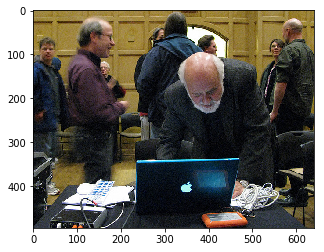

In [8]:
impath = '/home/ec2-user/SageMaker/GitHub/SageMaker-CustomMXNet-Autoscaling/Lab2/dcn/demo/COCO_test2015_000000000891.jpg'

img = imread(impath)
imshow(img)

In [9]:
impath = '/home/ec2-user/SageMaker/GitHub/SageMaker-CustomMXNet-Autoscaling/Lab2/dcn/demo/769452-1.2.jpg'

In [10]:
%%time

with open(impath, 'rb') as f:
    payload = f.read()

image_packet = impb.PBImage()
image_packet.image_data = payload

predictor.serializer = None
predictor.deserializer = StringDeserializer()
predictor.accept = None
predictor.content_type = 'application/octet-stream'

response = predictor.predict(image_packet.SerializeToString())          


CPU times: user 24.3 ms, sys: 0 ns, total: 24.3 ms
Wall time: 408 ms


In [11]:
!ls -alh /home/ec2-user/SageMaker/GitHub/SageMaker-CustomMXNet-Autoscaling/Lab2/dcn/demo/769452-1.2.jpg

-rw-rw-r-- 1 ec2-user ec2-user 1.2M Aug 11 22:31 /home/ec2-user/SageMaker/GitHub/SageMaker-CustomMXNet-Autoscaling/Lab2/dcn/demo/769452-1.2.jpg


Let's look at our image prior to classification

In [12]:
impath = '/home/ec2-user/SageMaker/GitHub/SageMaker-CustomMXNet-Autoscaling/Lab2/dcn/demo/769452-1.2.jpg'

In [13]:
resp_list = []
for e in eval(response)['array']:
    resp_list.append(np.array(e))

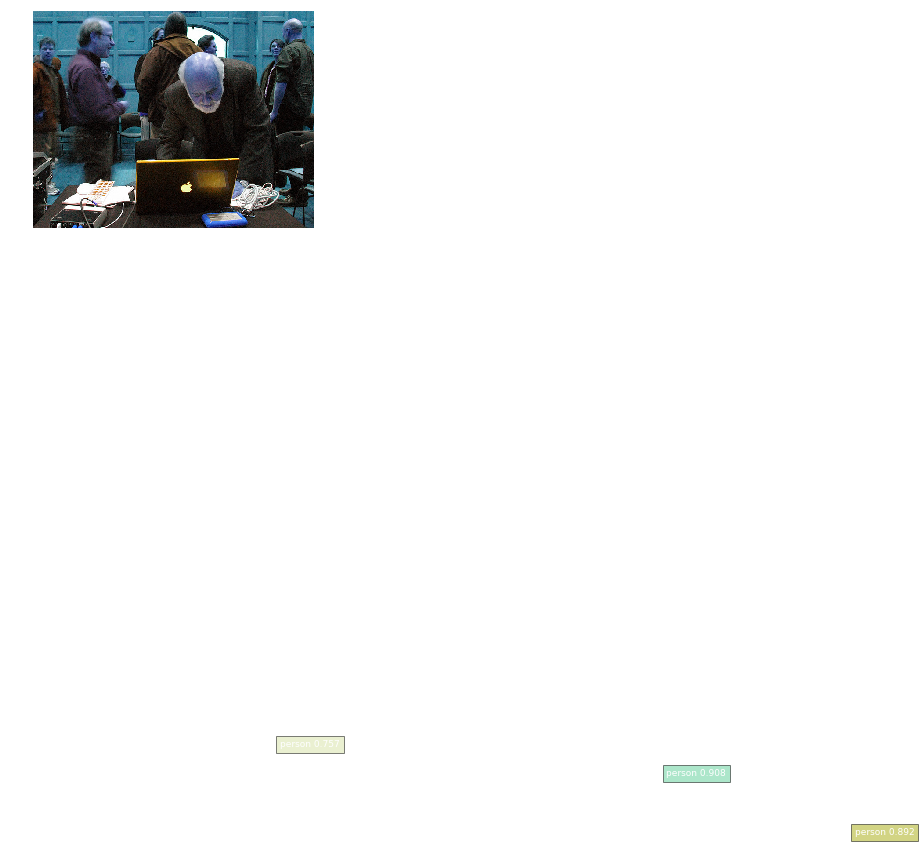

array([[[ 84, 138, 161],
        [ 77, 133, 158],
        [ 86, 143, 168],
        ...,
        [ 71, 130, 162],
        [ 64, 122, 157],
        [ 58, 130, 164]],

       [[ 81, 133, 156],
        [ 78, 132, 155],
        [ 81, 138, 160],
        ...,
        [ 63, 127, 157],
        [ 60, 127, 158],
        [ 44, 126, 157]],

       [[ 85, 137, 160],
        [ 86, 138, 161],
        [ 84, 138, 161],
        ...,
        [ 54, 125, 152],
        [ 53, 133, 158],
        [ 40, 132, 157]],

       ...,

       [[ 36,  30,  25],
        [ 44,  34,  27],
        [ 74,  60,  54],
        ...,
        [ 37,  68,  83],
        [ 17,  61,  74],
        [ 34,  68,  84]],

       [[ 43,  32,  28],
        [ 67,  52,  49],
        [ 78,  59,  54],
        ...,
        [ 48,  78,  89],
        [ 29,  71,  83],
        [ 44,  76,  89]],

       [[ 72,  57,  55],
        [ 69,  50,  47],
        [ 78,  56,  51],
        ...,
        [ 53,  82,  89],
        [ 30,  72,  79],
        [ 44,  74,  85]]

In [14]:
#im = cv2.imread('./dcn/demo/' + im_name)
im = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
show_boxes(im, resp_list, classes, 1)

10 loops, best of 3: 165 ms per loop


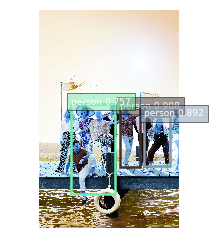

array([[[243, 230, 204],
        [243, 230, 204],
        [243, 230, 204],
        ...,
        [237, 202, 158],
        [237, 202, 158],
        [237, 202, 158]],

       [[243, 230, 204],
        [243, 230, 204],
        [243, 230, 204],
        ...,
        [237, 202, 158],
        [237, 202, 158],
        [237, 202, 158]],

       [[244, 231, 205],
        [244, 231, 205],
        [244, 231, 205],
        ...,
        [236, 201, 157],
        [236, 201, 157],
        [236, 201, 157]],

       ...,

       [[240, 245, 214],
        [233, 238, 207],
        [226, 228, 198],
        ...,
        [106,  75,  36],
        [106,  75,  36],
        [107,  76,  37]],

       [[249, 236, 214],
        [241, 227, 205],
        [227, 213, 191],
        ...,
        [106,  75,  36],
        [107,  76,  37],
        [108,  77,  38]],

       [[249, 230, 225],
        [241, 222, 217],
        [232, 212, 207],
        ...,
        [103,  72,  33],
        [104,  73,  34],
        [105,  74,  35]]

In [15]:
impath = '/home/ec2-user/SageMaker/GitHub/SageMaker-CustomMXNet-Autoscaling/Lab2/dcn/demo/769452-1.2.jpg'
#impath = '/home/ec2-user/SageMaker/GitHub/SageMaker-CustomMXNet-Autoscaling/Lab2/dcn/demo/769452-2.4.jpg'
img = imread(impath)

with open(impath, 'rb') as f:
    payload = f.read()

image_packet = impb.PBImage()
image_packet.image_data = payload

predictor.serializer = None
predictor.deserializer = StringDeserializer()
predictor.accept = None
predictor.content_type = 'application/octet-stream'

%timeit response = predictor.predict(image_packet.SerializeToString())          

resp_list = []
for e in eval(response)['array']:
    resp_list.append(np.array(e))
    
im = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
show_boxes(im, resp_list, classes, 1)    

In [17]:
import numpy as np 
import datetime
import math
import time
import boto3   
import matplotlib.pyplot as plt

endpoint_name=predictor.endpoint
total_runs=1000

In [18]:
print('Running {} inferences for {}:'.format(total_runs, endpoint_name))

client_times = []
cw_start = datetime.datetime.utcnow()

for i in range(total_runs):    
    
    client_start = time.time()
    
    response = predictor.predict(image_packet.SerializeToString())
        
    client_end = time.time()
    client_times.append((client_end - client_start)*1000)


cw_end = datetime.datetime.utcnow()    
    
print('Client end-to-end latency percentiles:')
client_avg = np.mean(client_times)
client_p50 = np.percentile(client_times, 50)
client_p90 = np.percentile(client_times, 90)
client_p95 = np.percentile(client_times, 95)
client_p100 = np.percentile(client_times, 100)
print('Avg | P50 | P90 | P95 | P100')
print('{:.4f} | {:.4f} | {:.4f} | {:.4f}\n'.format(client_avg, client_p50, client_p90, client_p95, client_p100))

print('Getting Cloudwatch:')
cloudwatch = boto3.client('cloudwatch')
statistics=['SampleCount', 'Average', 'Minimum', 'Maximum']
extended=['p50', 'p90', 'p95', 'p100']

# Give 5 minute buffer to end
cw_end += datetime.timedelta(minutes=5)

# Period must be 1, 5, 10, 30, or multiple of 60
# Calculate closest multiple of 60 to the total elapsed time
factor = math.ceil((cw_end - cw_start).total_seconds() / 60)
period = factor * 60
period = int(period)

print('Time elapsed: {} seconds'.format((cw_end - cw_start).total_seconds()))
print('Using period of {} seconds\n'.format(period))

cloudwatch_ready = False
# Keep polling CloudWatch metrics until datapoints are available
while not cloudwatch_ready:
  time.sleep(30)
  print('Waiting 30 seconds ...')
  # Must use default units of microseconds
  model_latency_metrics = cloudwatch.get_metric_statistics(MetricName='ModelLatency',
                                             Dimensions=[{'Name': 'EndpointName',
                                                          'Value': endpoint_name},
                                                         {'Name': 'VariantName',
                                                          'Value': "AllTraffic"}],
                                             Namespace="AWS/SageMaker",
                                             StartTime=cw_start,
                                             EndTime=cw_end,
                                             Period=period,
                                             Statistics=statistics,
                                             ExtendedStatistics=extended
                                             )
  # Should be 1000
  if len(model_latency_metrics['Datapoints']) > 0:
    print('{} latency datapoints ready'.format(model_latency_metrics['Datapoints'][0]['SampleCount']))
    side_avg = model_latency_metrics['Datapoints'][0]['Average'] / total_runs
    side_p50 = model_latency_metrics['Datapoints'][0]['ExtendedStatistics']['p50'] / total_runs
    side_p90 = model_latency_metrics['Datapoints'][0]['ExtendedStatistics']['p90'] / total_runs
    side_p95 = model_latency_metrics['Datapoints'][0]['ExtendedStatistics']['p95'] / total_runs
    side_p100 = model_latency_metrics['Datapoints'][0]['ExtendedStatistics']['p100'] / total_runs
    print('Avg | P50 | P90 | P95 | P100')
    print('{:.4f} | {:.4f} | {:.4f} | {:.4f}\n'.format(side_avg, side_p50, side_p90, side_p95, side_p100))

    cloudwatch_ready = True
    

Running 1000 inferences for mxnet-serving-160-gpu-py2-2020-08-11-23-46-52-366:
Client end-to-end latency percentiles:
Avg | P50 | P90 | P95 | P100
162.1235 | 161.4240 | 163.5791 | 165.6085

Getting Cloudwatch:
Time elapsed: 462.128676 seconds
Using period of 480 seconds

Waiting 30 seconds ...
880.0 latency datapoints ready
Avg | P50 | P90 | P95 | P100
135.9357 | 135.5927 | 146.3247 | 147.8440



In [ ]:
#client_times

In [ ]:
fig = plt.figure(figsize=(80, 60))
ax = fig.add_subplot(111)
ax.plot(client_times)